<a name='1'></a>
## 1 - Packages

Run the following code cell to import the necessary packages and dependencies you will need to perform Neural Style Transfer.

In [ ]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
%matplotlib inline

In [ ]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

vgg.trainable = False
pp.pprint(vgg)

In [ ]:
content_image = Image.open("/content/cute-virat-kohli-jofl0v6grajz01jl.jpg")

content_image

In [ ]:

def compute_content_cost(content_output, generated_output):

    a_C = content_output[-1]
    a_G = generated_output[-1]

    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C]) # Or tf.reshape(a_C, shape=[m, -1 , n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C]) # Or tf.reshape(a_G, shape=[m, -1 , n_C])


    J_content =  tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4.0 * n_H * n_W * n_C)



    return J_content

In [ ]:
tf.random.set_seed(1)
a_C = tf.random.normal([1, 1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 1, 4, 4, 3], mean=1, stddev=4)
J_content = compute_content_cost(a_C, a_G)
J_content_0 = compute_content_cost(a_C, a_C)
assert type(J_content) == EagerTensor, "Use the tensorflow function"
assert np.isclose(J_content_0, 0.0), "Wrong value. compute_content_cost(A, A) must be 0"
assert np.isclose(J_content, 7.0568767), f"Wrong value. Expected {7.0568767},  current{J_content}"

print("J_content = " + str(J_content))

# Test that it works with symbolic tensors
ll = tf.keras.layers.Dense(8, activation='relu', input_shape=(1, 4, 4, 3))
model_tmp = tf.keras.models.Sequential()
model_tmp.add(ll)
try:
    compute_content_cost(ll.output, ll.output)
    print("done")
except Exception as inst:
    print("\n\033[91mDon't use the numpy API inside compute_content_cost\n")
    print(inst)

In [ ]:
example = Image.open("/content/ai-generated-8665654_1280.png")
example

In [ ]:


def gram_matrix(A):


    GA = tf.matmul(A, tf.transpose(A))



    return GA

In [ ]:
tf.random.set_seed(1)
A = tf.random.normal([3, 2 * 1], mean=1, stddev=4)
GA = gram_matrix(A)

assert type(GA) == EagerTensor, "Use the tensorflow function"
assert GA.shape == (3, 3), "Wrong shape. Check the order of the matmul parameters"
assert np.allclose(GA[0,:], [63.1888, -26.721275, -7.7320204]), "Wrong values."

print("GA = \n" + str(GA))

print("done")

In [ ]:

def compute_layer_style_cost(a_S, a_G):


    m, n_H, n_W, n_C = a_G.get_shape().as_list()


    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))

    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)


    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4.0 *(( n_H * n_W * n_C)**2))



    return J_style_layer

In [ ]:
tf.random.set_seed(1)
a_S = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_style_layer_GG = compute_layer_style_cost(a_G, a_G)
J_style_layer_SG = compute_layer_style_cost(a_S, a_G)


assert type(J_style_layer_GG) == EagerTensor, "Use the tensorflow functions"
assert np.isclose(J_style_layer_GG, 0.0), "Wrong value. compute_layer_style_cost(A, A) must be 0"
assert J_style_layer_SG > 0, "Wrong value. compute_layer_style_cost(A, B) must be greater than 0 if A != B"
assert np.isclose(J_style_layer_SG, 14.017805), "Wrong value."

print("J_style_layer = " + str(J_style_layer_SG))




Start by listing the layer names:

In [ ]:
for layer in vgg.layers:
    print(layer.name)

In [ ]:
vgg.get_layer('block5_conv4').output

In [ ]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [ ]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):



    J_style = 0

    a_S = style_image_output[:-1]

    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):

        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])


        J_style += weight[1] * J_style_layer

    return J_style

In [ ]:

@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):

    J = alpha * J_content + beta * J_style

    return J

In [ ]:
J_content = 0.2
J_style = 0.8
J = total_cost(J_content, J_style)

assert type(J) == EagerTensor, "Do not remove the @tf.function() modifier from the function"
assert J == 34, "Wrong value. Try inverting the order of alpha and beta in the J calculation"
assert np.isclose(total_cost(0.3, 0.5, 3, 8), 4.9), "Wrong value. Use the alpha and beta parameters"

np.random.seed(1)
print("J = " + str(total_cost(np.random.uniform(0, 1), np.random.uniform(0, 1))))

print("[done")

In [ ]:
content_image = np.array(Image.open("/content/cute-virat-kohli-jofl0v6grajz01jl.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

In [ ]:
style_image =  np.array(Image.open("/content/ai-generated-8665654_1280.png").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

In [ ]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

In [ ]:
def get_layer_outputs(vgg, layer_names):

    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

Save the outputs for the content and style layers in separate variables.

In [ ]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

In [ ]:

preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

In [ ]:

preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

Below are the utils that you will need to display the images generated by the style transfer model.

In [ ]:
def clip_0_1(image):

    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):

    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [ ]:


optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:

        a_G = vgg_model_outputs(generated_image)

        J_style = compute_style_cost(a_S, a_G)

        J_content = compute_content_cost(a_C, a_G)

        J = total_cost(J_content, J_style)


    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))

    return J

In [ ]:

generated_image = tf.Variable(generated_image)


J1 = train_step(generated_image)
print(J1)
assert type(J1) == EagerTensor, f"Wrong type {type(J1)} != {EagerTensor}"
assert np.isclose(J1, 25629.055, rtol=0.05), f"Unexpected cost for epoch 0: {J1} != {25629.055}"

J2 = train_step(generated_image)
print(J2)
assert np.isclose(J2, 17812.627, rtol=0.05), f"Unexpected cost for epoch 1: {J2} != {17735.512}"

print("92mAll tests passed")

Epoch 0 


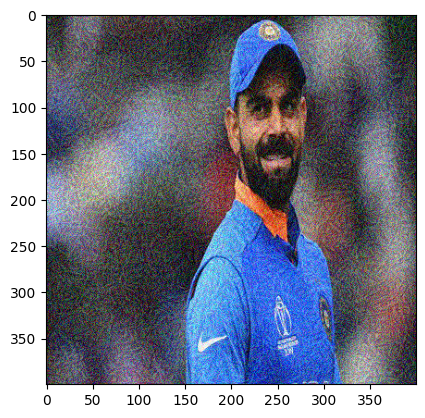

Epoch 250 


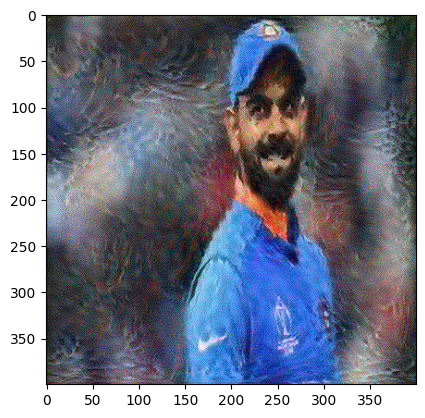

Epoch 500 


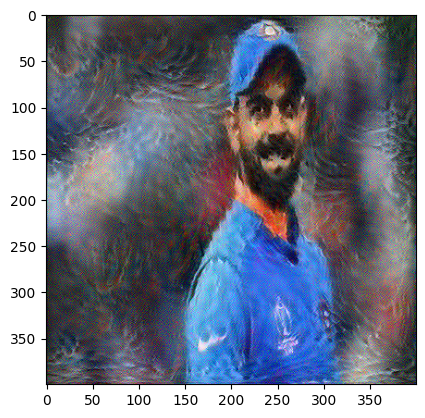

Epoch 750 


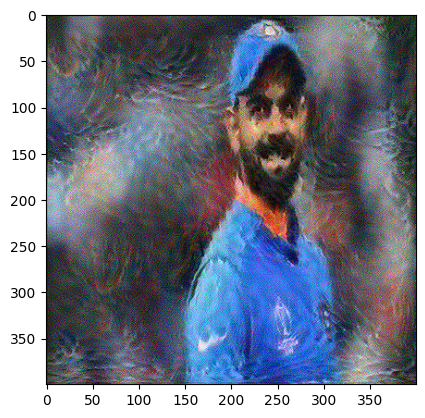

Epoch 1000 


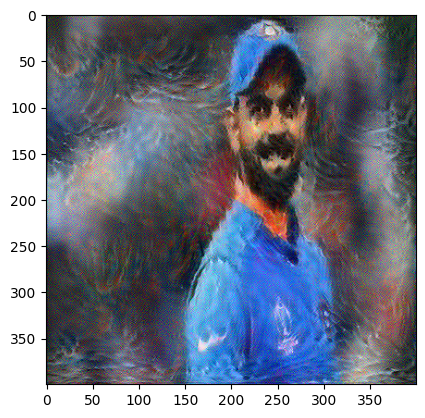

Epoch 1250 


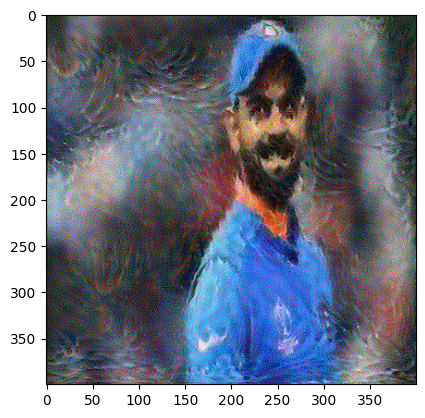

Epoch 1500 


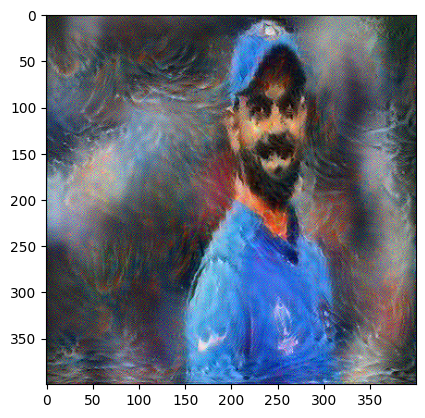

In [ ]:

epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"/content/output_{i}.jpg")
        plt.show()

Now, run the following code cell to see the results!

In [ ]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()